# Credit Card Fraud Detection using Gaussian Naive Bayes Classifier

The dataset used was collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. It contains transactions made through credit cards in September 2013 by European cardholders. The data set has 492 frauds out of 284,807 transactions (0.172%) and thus is highly unbalanced. The features are numerical values generated using PCA transformation of the original features (for the sake of confidentiality). Features V1, V2, … V28 are the principal components obtained with PCA. Features 'Time' and 'Amount' are were not transformed, however. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Data set description taken from: https://www.kaggle.com/lovedeepsaini/fraud-detection-with-naive-bayes-classifier/data?<br>
Some ideas taken from: https://www.kaggle.com/lovedeepsaini/fraud-detection-with-naive-bayes-classifier/data

## Import Libraries

In [1]:
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas import DataFrame

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Preprocessing Module

In [2]:
class Preprocessing:
    def __init__(self):
        self.numerical_features_name_list_including_labels = None
        self.categorical_features_namelist = None
        #self.scaler_used_for_features = scaler_used_for_features
        self.labels = None
    
    
    
    
    #Custom train_test_split indices generator
    def train_test_split_indices(self, len_data, test_split_size):
        
        #Note that if a sample is to be dropped because of too many missing features, it should be done before this step.
        np.random.seed(42)
        shuffled_data_indices = np.random.permutation(len_data)
        total_test_data = int(test_split_size * len_data)
        testing_indices = shuffled_data_indices[:total_test_data]
        training_indices = shuffled_data_indices[total_test_data:]
        return training_indices, testing_indices
    
    
    def set_numerical_and_categorical_feature_names(self, dataframe):
        
        #get the names of the numeric feature columns only
        self.numerical_features_name_list_including_labels = dataframe.select_dtypes(include=np.number).columns.tolist()
        #get the names of the categorical feature columns only
        list_of_categorical_feature_names = []
        for feature in dataframe.columns:
            if dataframe.dtypes[feature] == "object":
                
                list_of_categorical_feature_names.append(feature)
        self.categorical_features_namelist = list_of_categorical_feature_names
        

## Gaussian Naive Bayes Implementation

In [3]:
class Classifier:
    
    def __init__(self, features_train, targets_train, features_test, targets_test):
        self.features_train = features_train
        self.targets_train = targets_train
        self.features_test = features_test
        self.targets_test = targets_test
        
        self.unique_classes = targets_train["Class"].unique()
        print("Unique classes are: ", self.unique_classes)
                
        self.training_sub_dataset_features_acc_to_classes = {}
        self.features_means_from_training_data = {}
        self.features_stdevs_from_training_data = {}
        self.class_prior_probabilities = {}
        
    
    
class Gaussian_Naive_Bayes(Classifier):
    
    def separate_train_set_by_class(self):
        
        for class_label in self.unique_classes:
            series_of_the_label_column = self.targets_train["Class"]
            indices_of_samples_with_this_label = series_of_the_label_column[series_of_the_label_column == class_label].index
            self.training_sub_dataset_features_acc_to_classes[class_label] = self.features_train.loc[indices_of_samples_with_this_label, :]
        
        print("\nThe data set is separated into different subsets based on the following keys:")
        for keyy in self.training_sub_dataset_features_acc_to_classes:
            print("Class label: ", keyy)
        
    
    
    def calculate_class_conditional_models_parameters(self):
        #The fit function  
        for class_label in self.unique_classes:
            #calculate the means of all the features for this class label
            self.features_means_from_training_data[class_label] = self.training_sub_dataset_features_acc_to_classes[class_label].mean(axis = 0)
            #calculate the stdevs of all the features for this class label
            self.features_stdevs_from_training_data[class_label] = self.training_sub_dataset_features_acc_to_classes[class_label].std(axis = 0)
#             print("\nFor label ", class_label, ": ")
#             print("Class Conditional Feature Means are: \n", self.features_means_from_training_data[class_label])
#             print("Class Conditional Feature Stdevs are: \n", self.features_stdevs_from_training_data[class_label])

    
    def calculate_class_priors(self):
        print("\nLearned Class Prior Probabilities:")
        for class_label in self.unique_classes:
            series_of_the_label_column = self.targets_train["Class"]
            total_samples_with_this_label = series_of_the_label_column[series_of_the_label_column == class_label].value_counts()
            #store each class prior in the dictionary, in the form of the log of the probability
            self.class_prior_probabilities[class_label] = total_samples_with_this_label.values/ len(self.targets_train)
            assert (self.class_prior_probabilities[class_label]) >= 0
            assert (self.class_prior_probabilities[class_label]) <= 1
            print("For label: ", class_label,": ",self.class_prior_probabilities[class_label])
    
           
            
    def calculate_probability_density(self, feature_x, meann, stdev):
        #use the density function for a univariate Gaussian distribution with parameters mean and stdev
        
        nume = (feature_x - meann) ** 2
        deno = (2 * (stdev ** 2))
        power = -( nume/deno)
        exponent = math.exp(power)
        density = (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent
        assert density >= 0 and density <= 1
        return density
    
    
    def predict_probs_of_sample_X_belonging_to_all_classes(self, sample_X):
        
        #calculate the log of class priors
        self.log_prob_of_lying_in_each_class = {}
        
        #Calculate log( p(y = k)) for each class k
        for class_label in self.unique_classes:
            self.log_prob_of_lying_in_each_class[class_label] = math.log(self.class_prior_probabilities[class_label], math.e)
        
        
        
        #predict the log probabilities that this sample lies in each of the classes
        for class_label in self.unique_classes:

            #calculate P(x_i | class) for each feature x_i, use log(prob(.)) since multiplying small probabilities ~ 0
            
            for feature in range(len(self.features_means_from_training_data)):
                prob_of_this_value_for_this_feature = self.calculate_probability_density(sample_X[feature], self.features_means_from_training_data[class_label][feature], self.features_stdevs_from_training_data[class_label][feature])
                assert prob_of_this_value_for_this_feature >= 0 and prob_of_this_value_for_this_feature <= 1
                log_of_prob_of_this_value_for_this_feature = math.log(prob_of_this_value_for_this_feature, math.e)
                self.log_prob_of_lying_in_each_class[class_label] += log_of_prob_of_this_value_for_this_feature
            
        #Now convert back to probabilities from log probabilities
        self.log_prob_of_lying_in_each_class = {label: math.e**self.log_prob_of_lying_in_each_class[label] for label in self.log_prob_of_lying_in_each_class}
        
        
        return self.log_prob_of_lying_in_each_class    
        
            
        
    def predict_class_of_all_samples_in_test_set(self, all_samples_in_test_set):
        
        label_predictions_for_all_samples = []
        
        #Iterate through all the samples
        for index, sample_X in all_samples_in_test_set.iterrows():
            predicted_label = None
            max_prob = 0
            for label, prob_of_having_this_label in self.predict_probs_of_sample_X_belonging_to_all_classes(sample_X).items():
                if prob_of_having_this_label > max_prob:
                    predicted_label = label
                    max_prob = prob_of_having_this_label
            label_predictions_for_all_samples.append(predicted_label)
            
        return label_predictions_for_all_samples        

## Execution Begins

In [4]:
path = r"C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Naive_Bayes_Classifier\data\gaussian_data\creditcard.csv"
raw_data = pd.read_csv(path, sep = ",")

#maintain a separate copy of the data for future purpose
COPY_OF_RAW_DATA = copy.deepcopy(raw_data)


preprocessing = Preprocessing()

training_indices, testing_indices = preprocessing.train_test_split_indices(len(raw_data), 0.2)
train_set, test_set = raw_data.iloc[training_indices], raw_data.iloc[testing_indices]
preprocessing.set_numerical_and_categorical_feature_names(train_set)

Since Naive Bayes classifier learns class prior from the data set, it is important that the training data is stratified so that the class priors represent a good approximation of the true distribution that generated the data set. Lets plot the class distribution using a pie-chart for this purpose.

Text(0, 0.5, '')

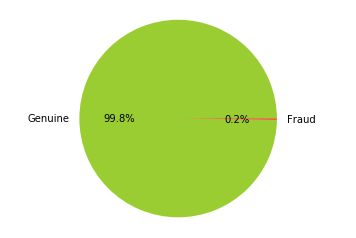

In [5]:
fig, ax = plt.subplots(1,1)
ax.pie(train_set.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

It appears that the training data has a higly imbalanced proportion of the two classes present. In another notebook, we showed that using a Gaussian Naive Bayes classifier on this imbalanced data set does not give a good precision and recall on the test set. This can be remedied using different methods such as upsampling, downsampling, etc.

## Undersampling and Oversampling

The number of samples in each of the classes in the hybrid train set:  1    113923
0    113923
Name: Class, dtype: int64


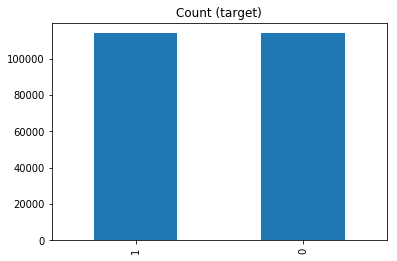

In [6]:
# Class count in train set
class_0_in_train_set, class_1_in_train_set = train_set.Class.value_counts()


#Divide the training data set by class
train_set_class_0_samples = train_set[train_set['Class'] == 0]
train_set_class_1_samples = train_set[train_set['Class'] == 1]

#Since we are using a hybrid of undersampling and oversampling, fix a middle point N between the number of samples in
#class 0  and the number of samples in class 1 such that we increase the class 1 count to N and decrease the class 0
#count to N.

mid = int(class_0_in_train_set + ((class_1_in_train_set-class_0_in_train_set)/ 2.))

train_set_class_0_samples_undersampled = train_set_class_0_samples.sample(mid)

train_set_class_1_samples_over = train_set_class_1_samples.sample(mid, replace=True)

train_set = pd.concat([train_set_class_0_samples_undersampled, train_set_class_1_samples_over], axis=0)

print("The number of samples in each of the classes in the hybrid train set: ",train_set.Class.value_counts())
train_set.Class.value_counts().plot(kind='bar', title='Count (target)')

The train set is now balaned.

### Summary of the data set

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227846 entries, 132046 to 157585
Data columns (total 31 columns):
Time      227846 non-null float64
V1        227846 non-null float64
V2        227846 non-null float64
V3        227846 non-null float64
V4        227846 non-null float64
V5        227846 non-null float64
V6        227846 non-null float64
V7        227846 non-null float64
V8        227846 non-null float64
V9        227846 non-null float64
V10       227846 non-null float64
V11       227846 non-null float64
V12       227846 non-null float64
V13       227846 non-null float64
V14       227846 non-null float64
V15       227846 non-null float64
V16       227846 non-null float64
V17       227846 non-null float64
V18       227846 non-null float64
V19       227846 non-null float64
V20       227846 non-null float64
V21       227846 non-null float64
V22       227846 non-null float64
V23       227846 non-null float64
V24       227846 non-null float64
V25       227846 non-null float64


There is no null value in the data set. Hence, no null value removal or imputation required. All features are numerical, so no encoding required.

In [8]:
train_set.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,...,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000
mean,87105.711687,-2.234121,1.777593,-3.435317,2.280678,-1.494722,-0.718457,-2.711718,0.351887,-1.282144,...,0.365593,0.004371,-0.045921,-0.052386,0.013268,0.032453,0.093316,0.041780,99.329603,0.500000
std,48388.191382,5.298272,3.552007,6.036305,3.194920,4.115407,1.723916,5.623031,4.507054,2.294638,...,2.568325,1.100216,1.228419,0.567973,0.685263,0.478297,0.983864,0.438491,247.805487,0.500001
min,0.000000,-41.928738,-63.344698,-48.325589,-5.401678,-113.743307,-20.367836,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-36.666000,-2.836627,-7.495741,-2.604551,-9.543518,-15.430084,0.000000,0.000000
25%,44393.000000,-2.740483,-0.124090,-5.167885,-0.120036,-1.730411,-1.602523,-3.059245,-0.199580,-2.309829,...,-0.166561,-0.536707,-0.245773,-0.404389,-0.322931,-0.285366,-0.061962,-0.059733,1.290000,0.000000
50%,80000.500000,-0.736660,0.978705,-1.369655,1.326303,-0.393733,-0.649763,-0.665364,0.158336,-0.711705,...,0.146935,0.025741,-0.036490,0.005042,0.056276,-0.007772,0.047135,0.034382,18.000000,0.500000
75%,133949.000000,1.068282,2.871121,0.337194,4.342228,0.507244,0.047446,0.262001,0.856122,0.165710,...,0.645103,0.566844,0.187155,0.382801,0.389869,0.330020,0.440443,0.207534,99.990000,1.000000
max,172792.000000,2.451888,22.057729,4.187811,16.875344,29.162172,73.301626,120.589494,20.007208,10.348407,...,27.202839,10.503090,19.228169,4.584549,5.852484,3.415636,31.612198,15.870474,25691.160000,1.000000


As seen above, except for two features, "time" and "amount", all other features do not have an interpretation in terms of the original features. "time" is the number of seconds that have elapsed between the first transaction and this each sample. To see whether there is a trend on which class a sample lies in based on the amount of time that has elasped between the first transaction and a particular transaction, we can plot the number of transactions for each step in time. However, since the time is in seconds and the maximum value is 25691.160 seconds, it is important that we scale the x-axis (the time feature) down to a range the suits our display and thus helps us to make better conclusions.

In [9]:
train_set["hours_passed"] = train_set["Time"]/3600 # convert to hours
print(train_set["hours_passed"].tail(5))

15751      7.551944
141257    23.390000
79874     16.171389
154676    28.483889
157585    30.579722
Name: hours_passed, dtype: float64


Lets drop the original feature "Time"

In [10]:
train_set = train_set.drop(['Time'],axis=1)

Text(0, 0.5, 'No. of  transactions')

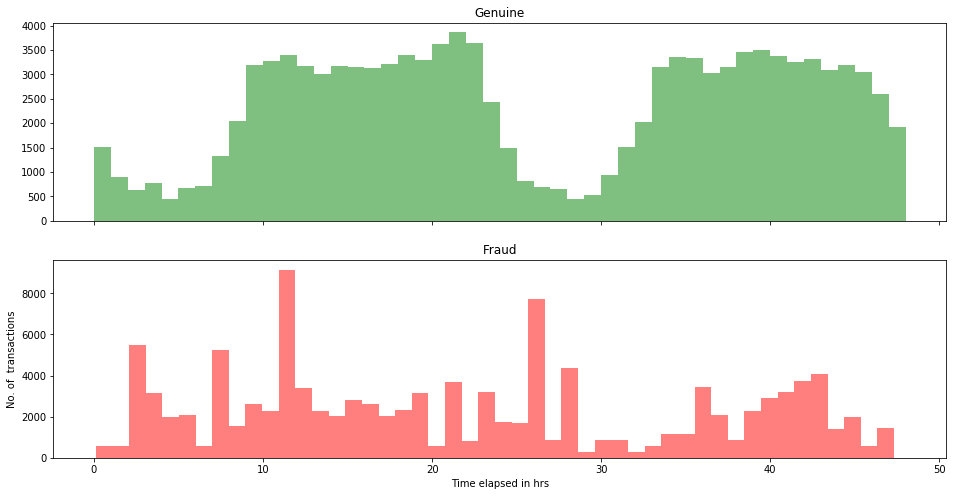

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(16,8))
ax1.hist(train_set.hours_passed[train_set.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(train_set.hours_passed[train_set.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time elapsed in hrs')
plt.ylabel('No. of  transactions')

From the histograms above, it is apparent that the maximum value that this new feature can take is within 0 and 50. The trends in both fraud and genuine classes are similar as the time progresses and are not discernible from each other in any way based on the number of hours passed since the first transaction. Hence, not much can be said about the classification just from the time feature.

Another such feature that we can look into to see of there is any trend is "Amount". One scenario in which plotting such information would be helpful is if all the transactions above a certain value were one class and all the other transactions were the other class. Before doint that, lets note that while all PCA features have a mean around zero and a standard deviation very close to one, feature "amount" is on a much larger scale. Hence, lets standardize it before plotting the trend.

Text(0, 0.5, 'No. of transactions')

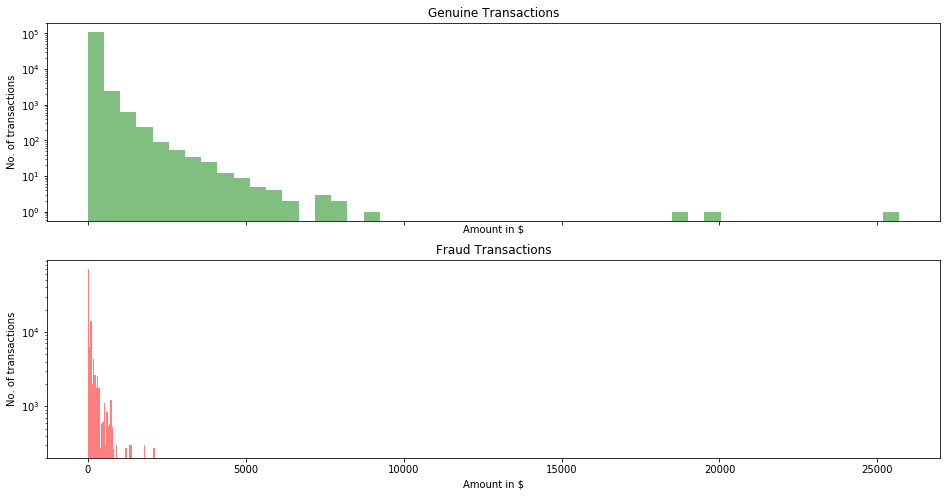

In [12]:
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (16,8), sharex = True)
ax3.hist(train_set.Amount[train_set.Class==0],bins=50,color='g',alpha=0.5)

#use log scale in y axis to see the tails in the x axis
ax3.set_yscale('log')
ax3.set_title('Genuine Transactions')
ax3.set_xlabel('Amount in $')
ax3.set_ylabel('No. of transactions')
ax4.hist(train_set.Amount[train_set.Class==1],bins=50,color='r',alpha=0.5)

#use log scale in y axis to see the tails in the x axis
ax4.set_yscale('log')
ax4.set_title('Fraud Transactions') # to see the tails
ax4.set_xlabel('Amount in $')
ax4.set_ylabel('No. of transactions')

There is no clear separation between the genuine and fraud transactions based in the amount of transaction as there is a significant overlap for transaction amount range (0$, ~2000$). However, one information that can be noted is that all the transactions with amount larger than 5000$ are in the genuine class.

Since this "Amount" feature, like the time feature, is on a scale much larger than the PCA features, lets standardize this feature.

In [13]:
scaler = StandardScaler()
scaler.fit(train_set['Amount'].values.reshape(-1,1))
train_set['scaled_amount'] = scaler.transform(train_set['Amount'].values.reshape(-1,1))
train_set = train_set.drop(['Amount'],axis=1)

In [14]:
train_set.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,hours_passed,scaled_amount
132046,-1.683052,0.886306,0.935316,-0.473839,-0.415403,-1.171479,0.142932,0.198052,-0.036846,-0.142831,...,-0.123064,-0.092698,0.427000,-0.268010,0.877853,-0.317746,0.051299,0,22.175556,-0.340306
159616,1.874604,2.393060,-4.375443,4.732008,2.481984,-1.908574,1.177723,-0.294804,-2.038520,-1.502406,...,-0.843925,-0.068062,-0.643631,0.225704,0.054471,0.009047,0.102908,0,31.312222,-0.376383
37323,-1.141198,1.091676,0.972342,-1.139885,-0.880839,-1.230209,0.949133,0.168551,-0.339499,-0.900607,...,-0.419707,0.150174,0.735459,-0.333072,0.628025,0.028261,0.083942,0,10.807500,0.022883
72008,-0.849659,0.764265,1.869881,-1.247202,-0.240178,-1.271934,0.820849,-0.280942,0.313668,-0.208826,...,-0.132650,-0.036502,0.740859,-0.356681,0.675569,0.199198,0.032006,0,15.146389,-0.322349
129179,-0.743755,0.853687,2.104754,1.771574,-0.848563,0.640388,-0.292556,0.755850,0.332982,-0.828022,...,-0.311905,0.097951,0.402798,-0.404736,-0.455729,0.111855,0.096720,0,21.939722,-0.332437


### Move the label to the end of the dataframe columns
The scaled features are to the right of the class label in the existing dataframe and we want the label at the for consistency.

In [15]:
col_names_to_order_at_the_end = ["hours_passed", "scaled_amount", "Class"]
new_col_order = train_set.columns.drop(col_names_to_order_at_the_end).to_list() + col_names_to_order_at_the_end
train_set = train_set[new_col_order]

train_set.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,hours_passed,scaled_amount,Class
132046,-1.683052,0.886306,0.935316,-0.473839,-0.415403,-1.171479,0.142932,0.198052,-0.036846,-0.142831,...,-0.123064,-0.092698,0.427000,-0.268010,0.877853,-0.317746,0.051299,22.175556,-0.340306,0
159616,1.874604,2.393060,-4.375443,4.732008,2.481984,-1.908574,1.177723,-0.294804,-2.038520,-1.502406,...,-0.843925,-0.068062,-0.643631,0.225704,0.054471,0.009047,0.102908,31.312222,-0.376383,0
37323,-1.141198,1.091676,0.972342,-1.139885,-0.880839,-1.230209,0.949133,0.168551,-0.339499,-0.900607,...,-0.419707,0.150174,0.735459,-0.333072,0.628025,0.028261,0.083942,10.807500,0.022883,0
72008,-0.849659,0.764265,1.869881,-1.247202,-0.240178,-1.271934,0.820849,-0.280942,0.313668,-0.208826,...,-0.132650,-0.036502,0.740859,-0.356681,0.675569,0.199198,0.032006,15.146389,-0.322349,0
129179,-0.743755,0.853687,2.104754,1.771574,-0.848563,0.640388,-0.292556,0.755850,0.332982,-0.828022,...,-0.311905,0.097951,0.402798,-0.404736,-0.455729,0.111855,0.096720,21.939722,-0.332437,0


## Use Class Conditional Densities to Check for the Gaussian Assumption

The Gaussian Naive Bayes classifier assumes that the class conditional for each feature follows a Gaussian distribution. This step is integrated to the feature selection step below since both the steps make use of the class conditional densities.

## Feature Selection using Class Conditional Densities

Not all features that we have are significantly helpful in our classification task. If the class conditional densities of a feature overlap significantly/ completely, this feature will not help in classification because there is not much distance between the two classes in the hyperspace on this axis. Lets see which features have (completely) overlapping class conditional densities so that we can remove them and thus reduce the model complexity without losing useful information.

Processing Column:  V1
Processing Column:  V2
Processing Column:  V3
Processing Column:  V4
Processing Column:  V5
Processing Column:  V6
Processing Column:  V7
Processing Column:  V8
Processing Column:  V9
Processing Column:  V10
Processing Column:  V11
Processing Column:  V12
Processing Column:  V13
Processing Column:  V14
Processing Column:  V15
Processing Column:  V16
Processing Column:  V17
Processing Column:  V18
Processing Column:  V19
Processing Column:  V20
Processing Column:  V21
Processing Column:  V22
Processing Column:  V23
Processing Column:  V24
Processing Column:  V25
Processing Column:  V26
Processing Column:  V27
Processing Column:  V28
Processing Column:  hours_passed
Processing Column:  scaled_amount


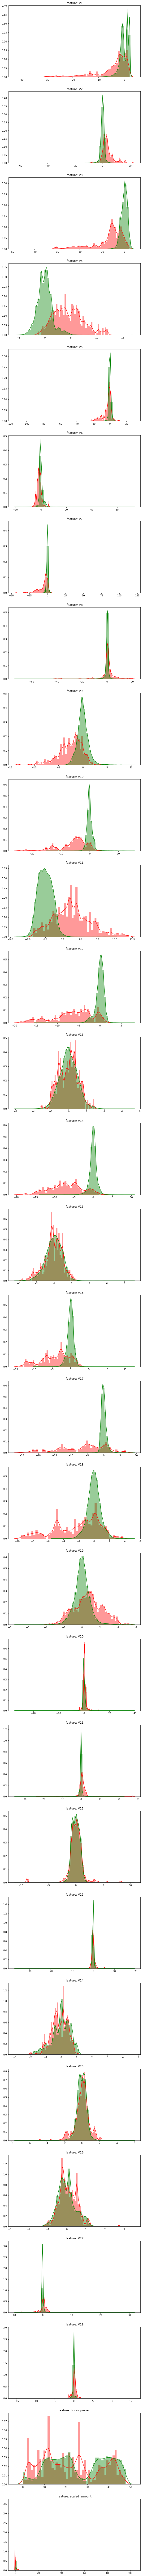

In [16]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(30, 1)

plt.figure(figsize=(10,50*4))

for i, col in enumerate(train_set[train_set.columns[~train_set.columns.isin(["Class"])]]):
    print("Processing Column: ", col)
    ax5 = plt.subplot(gs[i])
    sns.distplot(train_set[col][train_set.Class == 1], bins=50, color='r')
    sns.distplot(train_set[col][train_set.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))

plt.show()


It appears that all the class conditional densities have a somewhat gaussian distribution. In case the class conditional densities did not follow this assumption, we could discretize the features and then use multinomial naive bayes instead.

It can be observed that the class conditionals of the features v13, v15, v20, v22, v23, v24, v25, v26, v28, v29 overlap each other significantly. Hence we can remove these features without losing significant amount of information.

In [17]:
drop_list = ["V13", "V15", "V20", "V22", "V23", "V24", "V25", "V26", "V28"]
train_set = train_set.drop(drop_list, axis = 1)

### Modify the test set using the information gained on the train set before we used Naive Bayes

#Modifications that we made on the train set were:
1. Scale features "Time" and "Amount".
2. Reorder the columns
3. Drop features that are not useful for classification.

In [18]:
# 1.Scale features "Time" and "Amount".
test_set["hours_passed"] = test_set["Time"]/3600 # convert to hours

test_set['scaled_amount'] = scaler.transform(test_set['Amount'].values.reshape(-1,1))
test_set = test_set.drop(['Time', 'Amount'],axis=1)


In [19]:
# 2. Reorder the columns
col_names_to_order_at_the_end = ["hours_passed", "scaled_amount", "Class"]
new_col_order = test_set.columns.drop(col_names_to_order_at_the_end).to_list() + col_names_to_order_at_the_end
test_set = test_set[new_col_order]

test_set.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,hours_passed,scaled_amount,Class
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,11.529167,1.068826,1
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,12.294722,1.698071,0
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,9.856667,-0.275739,0
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,46.423056,-0.394785,0
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,46.798056,-0.397246,0


In [20]:
# 3. Drop the columns that are not helpful
#Also drop the same features from the test data set
test_set = test_set.drop(drop_list, axis = 1)
test_set.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V14,V16,V17,V18,V19,V21,V27,hours_passed,scaled_amount,Class
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-9.373859,-9.899247,-19.236292,-8.398552,3.101735,1.190739,-2.018575,11.529167,1.068826,1
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,-0.217884,-2.142892,0.126956,1.752662,0.432546,-0.213436,0.040996,12.294722,1.698071,0
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,-0.245772,1.769860,-0.533172,-0.533300,1.192245,0.102398,0.011409,9.856667,-0.275739,0
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,-0.550875,0.497974,0.502195,0.981343,0.101264,0.358932,-0.237386,46.423056,-0.394785,0
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,0.592634,0.091077,-0.471867,-0.333816,0.404711,-0.238644,-0.078043,46.798056,-0.397246,0


## Run Naive Bayes for Prediction

In [21]:
#Separate features and Labels
train_features = train_set[train_set.columns[~train_set.columns.isin(["Class"])]]
train_labels = train_set["Class"]

test_features = test_set[test_set.columns[~test_set.columns.isin(["Class"])]]
test_labels = test_set["Class"]


#Since the labels contain a single column, they are now a pandas series rather than a data frame, so convert
#into a data frame
train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

In [22]:
#Before moving forward, lets see the proportion of positive and negative labels in both train and test labels
unique_classes = train_labels["Class"].unique()
print("In Train Set, the total no. of samples in each label are:")

for class_label in unique_classes:
            series_of_the_label_column = train_labels["Class"]
            total_samples_with_this_label = series_of_the_label_column[series_of_the_label_column == class_label].value_counts()           
            print("For label: ", class_label,": ",total_samples_with_this_label.values/ len(train_labels))

unique_classes = test_labels["Class"].unique()          
print("In Test Set, the total no. of samples in each label are:")
for class_label in unique_classes:
            series_of_the_label_column = test_labels["Class"]
            total_samples_with_this_label = series_of_the_label_column[series_of_the_label_column == class_label].value_counts()            
            print("For label: ", class_label,": ",total_samples_with_this_label.values/ len(test_labels))


In Train Set, the total no. of samples in each label are:
For label:  0 :  [0.5]
For label:  1 :  [0.5]
In Test Set, the total no. of samples in each label are:
For label:  1 :  [0.00172048]
For label:  0 :  [0.99827952]


In [23]:
gaussian_nb = Gaussian_Naive_Bayes(train_features, train_labels, test_features, test_labels)

Unique classes are:  [0 1]


### Learn from the Training Data

In [24]:
# Calculate class priors
gaussian_nb.calculate_class_priors()


Learned Class Prior Probabilities:
For label:  0 :  [0.5]
For label:  1 :  [0.5]


In [25]:
# Separate the training data to calculate class conditional priors for different classes separately
gaussian_nb.separate_train_set_by_class()


The data set is separated into different subsets based on the following keys:
Class label:  0
Class label:  1


In [26]:
# Calculate class conditional gaussians' parameters
gaussian_nb.calculate_class_conditional_models_parameters()

### Predict labels of the test samples using the model learned above

In [27]:
predicted_labels = gaussian_nb.predict_class_of_all_samples_in_test_set(test_features)
print("Predicted Labels for the first three samples are: ", predicted_labels[0], predicted_labels[1], predicted_labels[2])
print("True Labels for the first three samples are: ", test_labels.iloc[0], test_labels.iloc[1], test_labels.iloc[2])

Predicted Labels for the first three samples are:  1 0 0
True Labels for the first three samples are:  Class    1
Name: 43428, dtype: int64 Class    0
Name: 49906, dtype: int64 Class    0
Name: 29474, dtype: int64


## Performance Measures

In [28]:
conf_matrix = confusion_matrix(test_labels, pd.DataFrame(predicted_labels))
accuracy = accuracy_score(test_labels, pd.DataFrame(predicted_labels))
precision = precision_score(test_labels, pd.DataFrame(predicted_labels), pos_label = 1)
recall = recall_score(test_labels, pd.DataFrame(predicted_labels), pos_label = 1 )


print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
print(f"\nConfusion Matrix: {conf_matrix}") # [ True Negative False positive] [ False Negative True Positive ]

Accuracy: 0.953599831463633, Precision: 0.018539538403329548, Recall: 0.5

Confusion Matrix: [[54269  2594]
 [   49    49]]
